# Task 2 - Model Building and Training

This notebook uses the processed data from Task 1 to build and compare two models (Logistic Regression and an Ensemble model) for fraud detection.

In [2]:
# Imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False

In [3]:
# Load processed train/test sets from Task 1
X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').squeeze()
y_test = pd.read_csv('../data/processed/y_test.csv').squeeze()
print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')
print(f'Class distribution in train: {y_train.value_counts().to_dict()}')
print(f'Class distribution in test: {y_test.value_counts().to_dict()}')

Train shape: (219136, 14), Test shape: (30223, 14)
Class distribution in train: {0: 109568, 1: 109568}
Class distribution in test: {0: 27393, 1: 2830}


In [4]:
def evaluate_model(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else y_pred
    f1 = f1_score(y_test, y_pred)
    auc_pr = average_precision_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    print(f'\n{model_name} Results:')
    print(f'F1-Score: {f1:.4f}')
    print(f'AUC-PR: {auc_pr:.4f}')
    print('Confusion Matrix:')
    print(cm)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=f'{model_name} (AUC-PR={auc_pr:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {model_name}')
    plt.legend()
    plt.show()
    return {'f1': f1, 'auc_pr': auc_pr, 'cm': cm}


Logistic Regression Results:
F1-Score: 0.2726
AUC-PR: 0.2397
Confusion Matrix:
[[18987  8406]
 [ 1057  1773]]


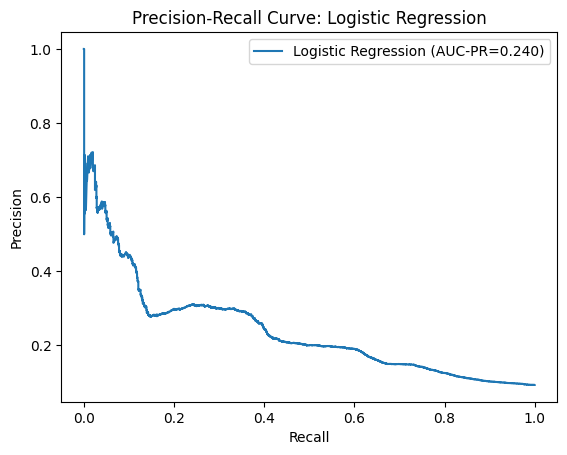

In [5]:
# Logistic Regression (Baseline)
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)
logreg_results = evaluate_model(logreg, X_test, y_test, 'Logistic Regression')

d:\GitHub\10acadamy\fraud-detection-adey-innovations\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:12:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Results:
F1-Score: 0.1817
AUC-PR: 0.5908
Confusion Matrix:
[[ 3526 23867]
 [  163  2667]]


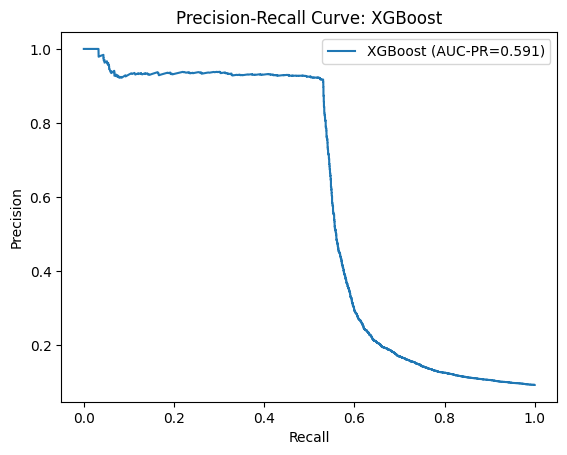

In [6]:
# Ensemble Model (Random Forest or XGBoost)
if xgb_available:
    ensemble = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=100, random_state=42)
    model_name = 'XGBoost'
else:
    ensemble = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    model_name = 'Random Forest'
ensemble.fit(X_train, y_train)
ensemble_results = evaluate_model(ensemble, X_test, y_test, model_name)

In [7]:
# Model Comparison and Justification
results = pd.DataFrame({
    'Model': ['Logistic Regression', model_name],
    'F1-Score': [logreg_results['f1'], ensemble_results['f1']],
    'AUC-PR': [logreg_results['auc_pr'], ensemble_results['auc_pr']]
})
print(results)
best = results.iloc[results['AUC-PR'].idxmax()]
print(f'\nBest model: {best["Model"]} (AUC-PR={best["AUC-PR"]:.4f}, F1={best["F1-Score"]:.4f})')
print('Justification: The best model is selected based on highest AUC-PR, which is most appropriate for imbalanced data. F1-Score and confusion matrix are also considered for overall performance.')

                 Model  F1-Score    AUC-PR
0  Logistic Regression  0.272581  0.239651
1              XGBoost  0.181651  0.590797

Best model: XGBoost (AUC-PR=0.5908, F1=0.1817)
Justification: The best model is selected based on highest AUC-PR, which is most appropriate for imbalanced data. F1-Score and confusion matrix are also considered for overall performance.
